In [8]:
import math
import copy
import numpy as np
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
import cvxpy as cp  
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [9]:
# initial value

nRotors = 8
Deg2Rad = np.pi /180
Rad2Deg = 1/Deg2Rad

dt = 0.01            # control frequency
tf = 4.5             # final time
g = 9.81              # m/s^2

l = 1.0              # m
m = 23.56            # kg
# m = 1000
Ix = 1.676           # kg m^2
Iy = 1.676           # kg m^2
Iz = 2.9743          # kg m^2

# rotor characteristics
kf = 1.1             # N / V^2
kt = 0.52            # N m / V^2 
rotor_limit = 10                  # rotor limit
rotor_sr_limit = rotor_limit/0.1  # rotor slew rate limit
omega_rotor, zeta_rotor = 40, 0.8

t_fail = 3         # 고장 시간
t_detect = 0.2     # 고장 검출에 걸리는 시간  
r_fail = 5         # 고장 로터 번호
c = l  
loc = np.zeros((nRotors,3))
loc[0] = np.array([ 0.25*c,  2.5*c, 0]) 
loc[1] = np.array([ 0.25*c,  1.5*c, 0])
loc[2] = np.array([ 0.25*c, -1.5*c, 0])
loc[3] = np.array([ 0.25*c, -2.5*c, 0])
loc[4] = np.array([-0.75*c, -2.5*c, 0])
loc[5] = np.array([-0.75*c, -1.5*c, 0])
loc[6] = np.array([-0.75*c,  1.5*c, 0])
loc[7] = np.array([-0.75*c,  2.5*c, 0])
thrust = np.array([0, 0, -kf])
moments = np.cross(loc, thrust)
A = np.zeros((4,nRotors))        # rotor speed (sq) to control (thr/torque)
A[0,:] = np.ones(nRotors)*kf     # thrust
A[[1,2],:] = moments[:,[0,1]].T  # roll moment , pitch moment
A[3,0::2] = -kt                  # yaw moment (CW rotors) 
A[3,1::2] =  kt                  # yaw moment (CCW rotors)
pinvA = np.linalg.pinv(A)

In [411]:
def compute_guidance_cvx(position, velocity, tgo,ub,lb,dt):
    s_time = time.time()
    delt = dt
    T = tgo
    N = int(T/delt)
    
    if N==0:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0 
        return np.array([thrust,phi_cmd,the_cmd,psi_cmd])

    r_des = np.zeros(3)
    r_des[0] = 1
    r_des[1] = 1
    r_des[2] = 0

    v_des = np.zeros(3)

    g_pin = np.zeros(3)
    g_pin[2] = 9.8
    T2 = ub
    T1 = lb
    T_c = cp.Variable((3*N))
    r_pin = cp.Variable((3,N+1))
    v_pin = cp.Variable((3,N+1))
    
    # mag = cp.norm(gamma,2)
    mag = cp.norm(T_c,2)
    obj = cp.Minimize(mag)

    # sum of root
    # obj=0
    # for t in range(N+1):
    #     obj += cp.norm(T_c[:,t],2)   
    # obj = cp.Minimize(obj)
    
    constr = [ 
        v_pin[:,0] == velocity,
        r_pin[:,0] == position,
        v_pin[:,-1] == v_des,
        r_pin[:,-1] == r_des
        ]
    
    # 3축 최적 추력 명령 산출
    
    for t in range(N):
        constr += [        
            r_pin[:,t+1] == r_pin[:,t] + v_pin[:,t]*delt,
            v_pin[:,t+1] == v_pin[:,t] + ( T_c[3*t:3*(t+1)]/m + g_pin )*delt,
            cp.norm(T_c[3*t:3*(t+1)]) <= T2,
            T_c[3*t+2]<=0,
        ]

    prob = cp.Problem(obj, constr)
    prob.solve(verbose=False,solver=cp.ECOS,reltol=1e-10)
    e_time = time.time()
    
    if prob.status=='optimal' or prob.status=='optimal_inaccurate':
        opt_T_c = np.reshape(T_c.value,(3,N),order='F')
        T_n, T_e, T_d = opt_T_c[0,:],opt_T_c[1,:],opt_T_c[2,:]
    
    # 추력 명령 -> 자세각 명령 변환 loop
    
        T_a =  T_n*np.cos(psi) + T_e*np.sin(psi)
        T_b = -T_n*np.sin(psi) + T_e*np.cos(psi)
    
        thrust = np.linalg.norm(opt_T_c,axis=0)
        the_cmd = -np.arctan2(T_a,-T_d)
        phi_cmd = np.arcsin(T_b/thrust)
        psi_cmd = psi
        print(tgo, prob.status)
    
    else:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0
        print(tgo, prob.status)
    
    if position[2]>=0:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0 
    print("IPM cost: ", np.linalg.norm(thrust))
    print("computed time: ",e_time-s_time)
    return np.array([thrust,opt_T_c,r_pin.value,v_pin.value])

In [412]:
def proj_onto_inner_product_cone(u,theta):
    u_prev = u[:3]
    u_next = u[3:]

    norm_prev = np.linalg.norm(u_prev)
    norm_next = np.linalg.norm(u_next)
    cos_alpha = u_prev@u_next.T/(norm_prev*norm_next)
    alpha = np.arccos(cos_alpha)

    if  cos_alpha >= math.cos(theta):
        u_prev_update = u[:3]
        u_next_update = u[3:]
    
    else:
        K = alpha -theta
        psi = np.arctan2( norm_next**2*np.sin(2*K),(norm_prev**2 + norm_next**2*np.cos(2*K)) )
        phi = psi/2
        normal_vec = np.cross(u_prev,u_next)

        A = np.array([u_prev,u_next,normal_vec])
        b1 = np.array([norm_prev**2*np.cos(phi)**2,norm_prev*norm_next*np.cos(phi)*np.cos(alpha-phi),0])
        b2 = np.array([norm_prev*norm_next*np.cos(K-phi)*np.cos(theta+phi),norm_next**2*np.cos(K-phi)**2,0])

        u_prev_update = np.linalg.solve(A,b1)
        u_next_update = np.linalg.solve(A,b2)
        
    return u_prev_update, u_next_update

def proj_onto_ub_lb_hemisphere(u_i,ub,lb):
    Tc_upper = ub
    Tc_lower = lb    
    u_update = u_i
    u_update[2] = min(0,u_update[2])

    Thr = np.sqrt(u_update[0]**2 + u_update[1]**2 + u_update[2]**2)

    if  Thr > Tc_upper:
        u_update[0] = Tc_upper*u_update[0]/Thr
        u_update[1] = Tc_upper*u_update[1]/Thr
        u_update[2] = Tc_upper*u_update[2]/Thr
    elif Thr < Tc_lower:
        u_update[0] = Tc_lower*u_update[0]/Thr
        u_update[1] = Tc_lower*u_update[1]/Thr
        u_update[2] = Tc_lower*u_update[2]/Thr
    else:
        pass

    return u_update

In [413]:
 def ADMM_consensus_compute_guidance(position, velocity, psi, tgo,ub,lb,alpha):
    s_time = time.time()
    delt = 0.1
    T = tgo
    N = int(T/delt)

    if N == 0 or N == 1:
        thrust, phi_cmd, the_cmd, psi_cmd = 0, 0, 0, 0 
        return np.array([thrust,phi_cmd,the_cmd,psi_cmd])
    
    Tc = ub
    Tc_lower = lb
    rho = 1e2
    lamb = 1e7

    G = np.zeros((3,3*N))
    H = np.zeros((3,3*N))
    I = np.eye(3*N)
    
    for i in range(N):
        G[:, 3*i:3*(i+1)] = (N-1-i)*delt**2/m*np.eye(3)
        H[:, 3*i:3*(i+1)] =  delt/m*np.eye(3)

    A = ssp.vstack((ssp.csr_matrix(G),ssp.csr_matrix(H)))
    A_tilde = ssp.vstack(( ssp.csr_matrix(G),ssp.csr_matrix(H),ssp.csr_matrix(I)/np.sqrt(lamb) ))
    
    pos_0 = position
    vel_0 = velocity

    pos_des = np.zeros(3)
    vel_des = np.zeros(3)

    g_pin = np.zeros(3)
    g_pin[2] = 9.807
    
    pos_pin = np.zeros((3,N+1))
    vel_pin = np.zeros((3,N+1))
    
    pos_pin[:,0] = pos_0
    vel_pin[:,0] = vel_0

    pos = pos_des - (pos_0 + N*delt*vel_0 + delt**2*(N-1)*N/2*g_pin)
    vel = vel_des - (vel_0 + N*delt*g_pin)
    
    b = np.hstack((pos,vel))
    b_tilde = np.hstack(( b,np.zeros(3*N) ))
    b_l2 = np.linalg.norm(b)

    z = sla.lsqr(A_tilde,b_tilde)[0]        # z initialize 
    x_i = np.zeros((3*N,N))
    u_i = np.zeros((3*N,N))
    
    x_bar = np.zeros(3*N)
    u_bar = np.zeros(3*N)
    x_bar_last = z
    r,s = 0,0
    
    mu = 10
    tau_incr,tau_decr = 2,2
    status = "Infeasible"

    max_iter = 10000
    for i in range(max_iter):
        ##################################################################################################
        for j in range(N):           
            v = z - u_i[:,0]               # x_0 update

        ##################################################################################################
            if j >= 1:                     # x_i update
                x_i[:,j] = z - u_i[:,j]
                thr_prev = x_i[3*(j-1):3*j,j] 
                thr_next = x_i[3*j:3*(j+1),j]
                thr_differ_mag = np.linalg.norm( thr_next - thr_prev )          
                if  alpha != False and thr_differ_mag > alpha :
                    x_i[3*(j-1):3*j,j] = (thr_next+thr_prev)/2 - (thr_next-thr_prev)/thr_differ_mag*alpha/2
                    x_i[3*j:3*(j+1),j] = (thr_next+thr_prev)/2 + (thr_next-thr_prev)/thr_differ_mag*alpha/2
        ################################################################################################## 
        # z update
        if alpha != False:
            for j in range(N):
                if j == 0:
                    x_bar[:3] = (x_i[:3,0]+x_i[:3,1])/2
                    u_bar[:3] = (u_i[:3,0]+u_i[:3,1])/2
                elif j == N-1:
                    x_bar[3*N-3:3*N] = (x_i[3*N-3:3*N,0]+x_i[3*N-3:3*N,N-1])/2                
                    u_bar[3*N-3:3*N] = (u_i[3*N-3:3*N,0]+u_i[3*N-3:3*N,N-1])/2                
                else:
                    x_bar[3*j:3*(j+1)] = (x_i[3*j:3*(j+1),0]+x_i[3*j:3*(j+1),j]+x_i[3*j:3*(j+1),j+1])/3
                    u_bar[3*j:3*(j+1)] = (u_i[3*j:3*(j+1),0]+u_i[3*j:3*(j+1),j]+u_i[3*j:3*(j+1),j+1])/3
        else:
            x_bar = x_i[:,0]
            u_bar = u_i[:,0]
        A_hat = ssp.vstack((A_tilde,np.sqrt(N*rho/(2*lamb))*I ))
        b_hat = np.hstack((b_tilde,np.sqrt(N*rho/(2*lamb))*(x_bar+u_bar)))
        z, istop = sla.lsqr(A_hat,b_hat)[:2]
        ##################################################################################################
        # u update
        for k in range(N):
            u_i[:,k] = u_i[:,k] + x_i[:,k] - z                  # dual ascent
        ##################################################################################################
        # Stopping Criterion 
            r += np.linalg.norm(x_i[:,k] - x_bar)**2            # Primal residual
        s = N*rho**2*((np.linalg.norm(x_bar - x_bar_last))**2)    # Dual residual
        Ax = x_i.flatten('F')    
        ATyk = rho*u_i.flatten('F')
        primal_res_l2 = np.sqrt(r)
        dual_res_l2 = np.sqrt(s)

        abstol, reltol = 1e-8, 1e-6
        ptol = np.sqrt(3*N**2)*abstol + reltol*max( np.linalg.norm(Ax), np.sqrt(N)*np.linalg.norm(z))
        dtol = np.sqrt(3*N**2)*abstol + reltol*np.linalg.norm((ATyk))
        x_bar_last = x_bar
        r,s = 0,0

        if  primal_res_l2 <= ptol and dual_res_l2 <= dtol:    # Stopping Criteria
            status = "Solved"
            break
        ##################################################################################################
    e_time = time.time()

    print("iter:",i,"status:",status,"pres_l2:",primal_res_l2, "dres_l2:",dual_res_l2,"ptol:", ptol,"dtol:",dtol)

    if position[2]>=0 or istop == 0 or status == "Infeasible":
        opt_T_c = np.reshape(z,(3,N),order='F')
        thrust = np.linalg.norm(opt_T_c,axis=0)
            
    else:
        opt_T_c = np.reshape(z,(3,N),order='F')
        thrust = np.linalg.norm(opt_T_c,axis=0)

    for t in range(N):
        pos_pin[:,t+1] = pos_pin[:,t] + vel_pin[:,t]*delt
        vel_pin[:,t+1] = vel_pin[:,t] + (z[3*t:3*(t+1)]/m + g_pin )*delt
    print("consensus admm: ", np.linalg.norm(thrust))
    print("computing time: %.4f" %(e_time - s_time))
    return np.array([thrust,opt_T_c,pos_pin,vel_pin])    

In [ ]:
def ADMM_compute_guidance(position, velocity,tgo,ub,lb,theta,dt):
    s_time = time.time()
    delt = dt
    T = tgo
    N = int(T/delt)
    rho = 1e0

    if N == 0 or N == 1:
        x, r_pin, v_pin = 0, 0, 0 
        return np.array([x, r_pin, v_pin])

    G = np.zeros((3,3*N))
    H = np.zeros((3,3*N))
    
    for i in range(N):
        G[:, 3*i:3*(i+1)] = (N-1-i)*delt**2/m*np.eye(3)
        H[:, 3*i:3*(i+1)] =  delt/m*np.eye(3)

    A = ssp.vstack((ssp.csc_matrix(G),ssp.csc_matrix(H) ))
    A_tilde = ssp.vstack((A,ssp.eye(3*N),ssp.eye(3*N),ssp.eye(3*N),ssp.eye(3*N)*np.sqrt(2/rho)))
    A_tilde_square = A_tilde.T@A_tilde
    A_tilde_inv = sla.inv(A_tilde_square)

    r_0 = position
    v_0 = velocity

    r_des = np.zeros(3)
    v_des = np.zeros(3)

    g_pin = np.zeros(3)
    g_pin[2] = 9.807
    

    pos = r_des - (r_0 + N*delt*v_0 + delt**2*(N-1)*N/2*g_pin)
    vel = v_des - (v_0 + N*delt*g_pin)

    A_init = ssp.vstack((ssp.csc_matrix(G),ssp.csc_matrix(H),ssp.eye(3*N)*np.sqrt(2/rho) ))

    b = np.hstack((pos,vel))
    b_tilde = np.hstack((pos,vel,np.zeros(3*N)))
    b_l2 = np.linalg.norm(b_tilde)

    x = sla.lsqr(A_init,b_tilde)[0]
    
    num_z = 3
    v = np.zeros(6)
    z = np.zeros((3*N,num_z))
    z_last = np.zeros((3*N,num_z))
    w = np.zeros((3*N,num_z))

    status = "Infeasible"

    max_iter = 5000

    for i in range(max_iter):
        if i!=0:
            x = A_tilde_inv@(A.T@(b-v) + z[:,0]-w[:,0] + z[:,1]-w[:,1] + z[:,2]-w[:,2])    # x update
    ##########################################################################################################################
        # z uodate
        for n in range(num_z):
            z[:,n] = x + w[:,n]
        for t in range(N):
            z[3*t:3*(t+1),0] = proj_onto_ub_lb_hemisphere(z[3*t:3*(t+1),0],ub,lb)
            if N % 2 == 0:
                if t <= N/2-1: 
                    z[6*t:6*t+3,1], z[6*t+3:6*(t+1),1] = proj_onto_inner_product_cone(z[6*t:6*(t+1),1],theta)
                if t < N/2-1:
                    z[3+6*t:6*t+6,2], z[6*t+6:3+6*(t+1),2] = proj_onto_inner_product_cone(z[3+6*t:3+6*(t+1),2],theta)
            else:
                if t <= (N-1)/2-1:
                    z[6*t:6*t+3,1], z[6*t+3:6*(t+1),1] = proj_onto_inner_product_cone(z[6*t:6*(t+1),1],theta)
                    z[3+6*t:3+6*t+3,2], z[3+6*t+3:3+6*(t+1),2] = proj_onto_inner_product_cone(z[3+6*t:3+6*(t+1),2],theta)
    ##########################################################################################################################
        # w update
        v = v + A@x -b
        for n in range(num_z):
            w[:,n] = w[:,n] + x - z[:,n]                  # dual ascent
    ##########################################################################################################################
        # stopping criterion
        r,s = 0,0
        r += np.linalg.norm(A*x-b)**2           # Primal residual
        r += np.linalg.norm(x-z[:,0])**2
        r += np.linalg.norm(x-z[:,1])**2
        r += np.linalg.norm(x-z[:,2])**2
        s += rho*(z[:,0] - z_last[:,0])  # Dual residual
        s += rho*(z[:,1] - z_last[:,1])  # Dual residual
        s += rho*(z[:,2] - z_last[:,2])  # Dual residual
        ATyk = np.linalg.norm(rho*A.T@v)**2 + np.linalg.norm(w[:,0]*rho)**2+np.linalg.norm(w[:,1]*rho)**2+np.linalg.norm(w[:,2]*rho)**2

        primal_res_l2 = np.linalg.norm(r)
        dual_res_l2 = np.linalg.norm(s)

        abstol, reltol = 1e-8, 1e-4
        ptol = np.sqrt(3*N+6)*abstol + reltol*max( np.linalg.norm(A_tilde*x), np.linalg.norm(z), b_l2)
        dtol = np.sqrt(3*N)*abstol + reltol*(np.sqrt(ATyk))

        z_last = z
        
        if  primal_res_l2 <= ptol and dual_res_l2 <= dtol:    # Stopping Criteria
            status = "Solved"
            break
    ##########################################################################################################################
    e_time = time.time()
    print("iter:",i,"status:",status,"pres_l2:",primal_res_l2, "dres_l2:",dual_res_l2,"ptol:", ptol,"dtol:",dtol)

    if position[2]>=0  or status == "Infeasible":
        opt_T_c = np.reshape(x,(3,N),order='F')
        thrust = np.linalg.norm(opt_T_c,axis=0)    
    else:
        opt_T_c = np.reshape(x,(3,N),order='F')
        thrust = np.linalg.norm(opt_T_c,axis=0)
   
    r_pin = np.zeros((3,N+1))
    v_pin = np.zeros((3,N+1))
    
    r_pin[:,0] = r_0
    v_pin[:,0] = v_0

    for t in range(N):
        r_pin[:,t+1] = r_pin[:,t] + v_pin[:,t]*delt
        v_pin[:,t+1] = v_pin[:,t] + (x[3*t:3*(t+1)]/m + g_pin )*delt
    print("ADMM cost: ", np.linalg.norm(thrust))
    print("computed time: ", e_time-s_time)
    
    return np.array([x,r_pin,v_pin])    

In [451]:
position = np.array([100,-150,-90])
velocity = np.array([30,-40,-20])
psi = 0
tgo = 140
ub = 400
lb = 0
dt = 0.5
N = int(tgo/dt)

t = np.arange(0., tgo, dt)
degree = 7.5
theta = degree*np.pi/180
thrust, u, r, v = compute_guidance_cvx(position, velocity, tgo,ub,lb,dt)
u_ADMM,r_ADMM,v_ADMM = ADMM_compute_guidance(position, velocity, tgo,ub,lb,theta,dt) 

140 optimal
IPM cost:  3819.8778714498535
computed time:  2.037256956100464
ipykernel_launcher:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:216: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
iter: 297 status: Solved pres_l2: 9.067482865062257 dres_l2: 0.0 ptol: 9.355180430463784 dtol: 0.7627991433292628
ADMM cost:  3813.7793482619227
computed time:  2.5525002479553223
ipykernel_launc

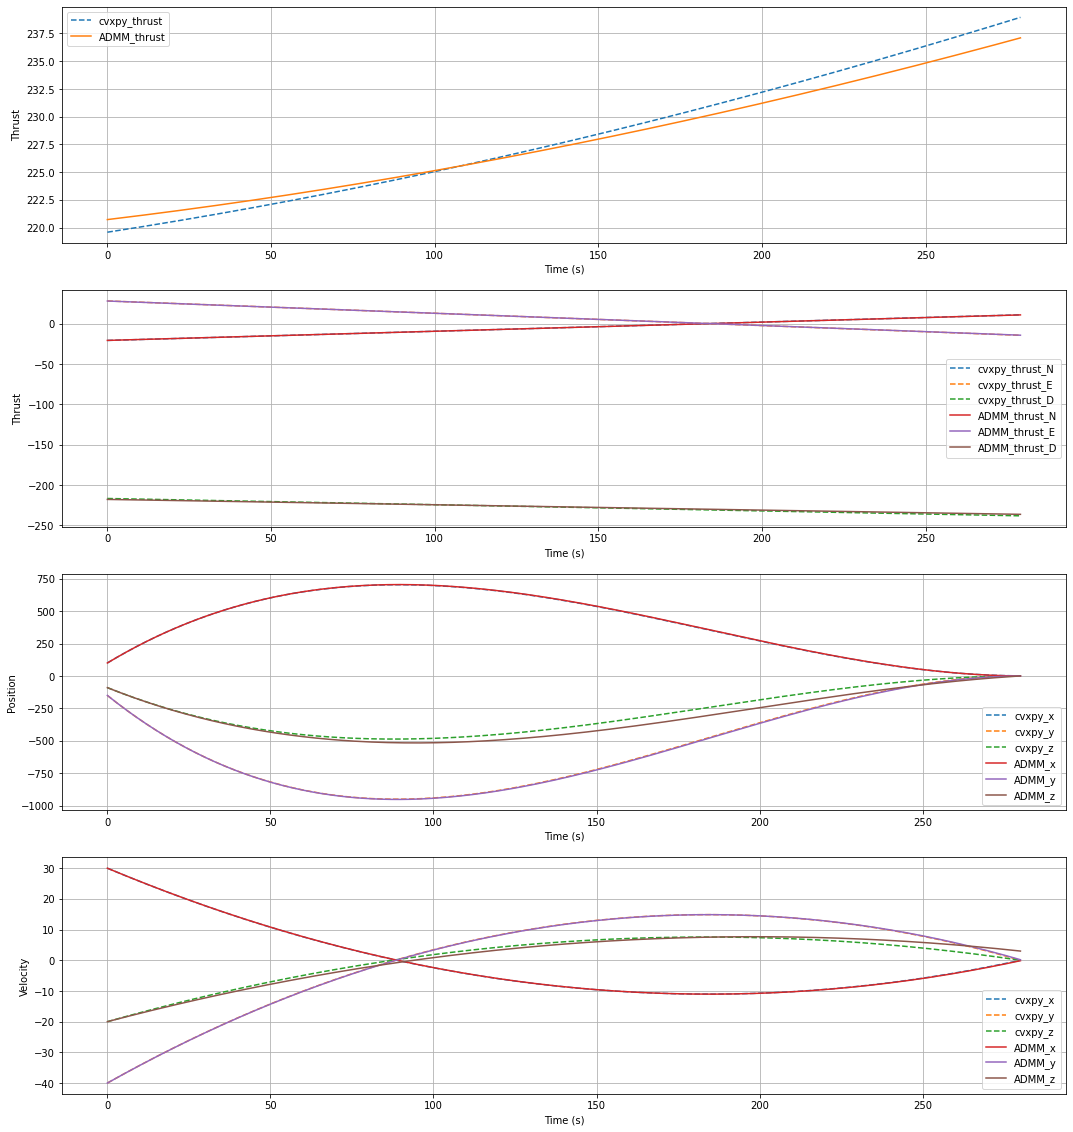

In [454]:
thrust_ADMM_NED = np.reshape(u_ADMM,(3,N),order='F')
thrust_ADMM = np.linalg.norm(thrust_ADMM_NED,axis=0)

plt.figure(num=6, figsize=(18,20))
plt.subplot(411)
# plt.plot(thrust_admm_consensus,label='consensus_ADMM')
# plt.plot(thrust_admm_consensus_alpha,'--',label='consensus_ADMM_alpha')
plt.plot(thrust,'--',label='cvxpy_thrust')
plt.plot(thrust_ADMM,label='ADMM_thrust')
plt.ylabel("Thrust")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()

plt.subplot(412)
plt.plot(u[0,:],'--',label='cvxpy_thrust_N')
plt.plot(u[1,:],'--',label='cvxpy_thrust_E')
plt.plot(u[2,:],'--',label='cvxpy_thrust_D')
plt.plot(thrust_ADMM_NED[0,:],label='ADMM_thrust_N')
plt.plot(thrust_ADMM_NED[1,:],label='ADMM_thrust_E')
plt.plot(thrust_ADMM_NED[2,:],label='ADMM_thrust_D')
plt.ylabel("Thrust")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()

plt.subplot(413)
plt.plot(r[0,:],'--',label='cvxpy_x')
plt.plot(r[1,:],'--',label='cvxpy_y')
plt.plot(r[2,:],'--',label='cvxpy_z')
plt.plot(r_ADMM[0,:],label='ADMM_x')
plt.plot(r_ADMM[1,:],label='ADMM_y')
plt.plot(r_ADMM[2,:],label='ADMM_z')
plt.ylabel("Position")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()

plt.subplot(414)
plt.plot(v[0,:],'--',label='cvxpy_x')
plt.plot(v[1,:],'--',label='cvxpy_y')
plt.plot(v[2,:],'--',label='cvxpy_z')
plt.plot(v_ADMM[0,:],label='ADMM_x')
plt.plot(v_ADMM[1,:],label='ADMM_y')
plt.plot(v_ADMM[2,:],label='ADMM_z')
plt.ylabel("Velocity")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()

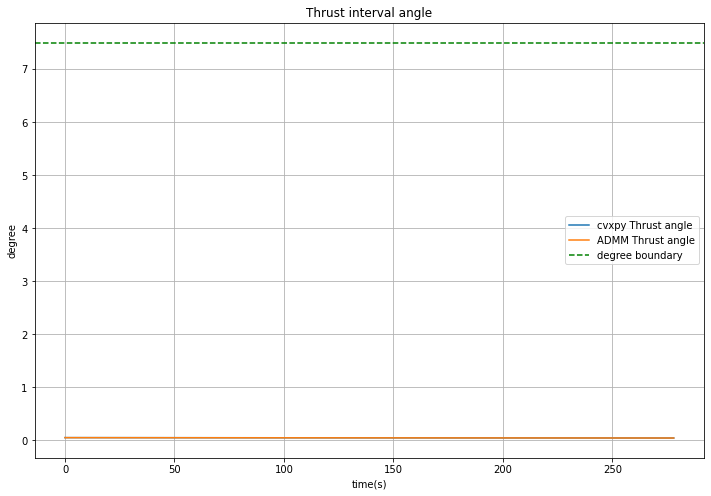

In [455]:
step_prev_ADMM = thrust_ADMM_NED[:,:-1]
thrust_prev_ADMM = thrust_ADMM[:-1]
step_next_ADMM = thrust_ADMM_NED[:,1:]
thrust_next_ADMM = thrust_ADMM[1:]

inner_product = np.sum((step_prev_ADMM*step_next_ADMM),axis=0)
radian_ADMM = np.arccos(inner_product/(thrust_prev_ADMM*thrust_next_ADMM))

step_prev = u[:,:-1]
thrust_prev = thrust[:-1]
step_next = u[:,1:]
thrust_next = thrust[1:]

inner_product = np.sum((step_prev*step_next),axis=0)
radian = np.arccos(inner_product/(thrust_prev*thrust_next))

plt.figure(figsize=(12,8))
plt.plot(radian*180/np.pi,label='cvxpy Thrust angle')
plt.plot(radian_ADMM*180/np.pi,label='ADMM Thrust angle')
plt.title('Thrust interval angle')
plt.xlabel('time(s)')
plt.ylabel('degree')
plt.axhline(y=degree, color='g', linestyle='--',label='degree boundary')
plt.legend()
plt.grid()